# Inspect the bump at ~20Msun

there is a hardnekkige bump at 20Msun that appears very clearly in the stable mass transfer channel, but also in other systems. 

* Why is it there? 

First let's plot the mass distribution so you know what I'm talking about:

In [8]:
"""
# Plotting the stable BH mass distribution for several SFRD Z-distribution variations
"""
import matplotlib
from matplotlib import rc
import matplotlib.cm as cm
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import h5py as h5 
import os
import time
from astropy.table import Table


data_dir = '../data/'
simulation_data = '/mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/'
sim_name = 'faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/'

######################################
## PLOT setttings
plt.rc('font', family='serif')
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize



In [2]:
sim_dir = simulation_data + sim_name

rate_key = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'


with h5.File(sim_dir + 'output/COMPAS_Output_wWeights.h5','r') as File:
        redshifts                 = File[rate_key]['redshifts'][()]
        DCO_mask                  = File[rate_key]['DCOmask'][()] # Mask from DCO to merging systems  
        #(contains filter for RLOF>CE and optimistic CE)
        intrinsic_rate_density    = File[rate_key]['merger_rate'][()]
        
        print(File.keys())

<KeysViewHDF5 ['BSE_Common_Envelopes', 'BSE_Double_Compact_Objects', 'BSE_RLOF', 'BSE_Supernovae', 'BSE_System_Parameters', 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned', 'Run_Details']>


## Some helper functions

In [3]:
#########################################
# Read LIgo data
#########################################
def read_ligo():
    color_plpeak = 'grey'
    ## grab Powerlaw + Peak data from O3
    mass_1 = np.linspace(2, 100, 1000)
    mass_ratio = np.linspace(0.1, 1, 500)
    with h5.File(data_dir+'o3only_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5', "r") as f:
        mass_ppd = f["ppd"]
        mass_lines = f["lines"]
        mass_1_ppd = np.trapz(mass_ppd, mass_ratio, axis=0)
        mass_1_lower = np.percentile(mass_lines["mass_1"], 5, axis=0)
        mass_1_upper = np.percentile(mass_lines["mass_1"], 95, axis=0)
    ##############################
    return mass_1, mass_1_lower, mass_1_upper, mass_1_ppd


#########################################
# Read COMPAS DCO data
#########################################
def read_data(loc = '', verbose=False):
    """
        Read DCO, SYS and merger rate data, necesarry to make the plots in this 
        
        Args:
            loc                  --> [string] Location of data
            rate_key             --> [string] group key name of COMPAS HDF5 data that contains your merger rate
            read_SFRD            --> [bool] If you want to also read in sfr data
            verbose              --> [bool] If you want to print statements while reading in 

        Returns:
            DCO                        --> [astropy table] contains all your double compact object
            DCO_mask                   --> [array of bool] reduces your DCO table to your systems of interest (determined in CI)
            rate_mask                  --> [array of bool] reduces intrinsic_rate_density to systems (flavour) of interest
            redshifts                  --> [array of floats] list of redshifts where you calculated the merger rate
            Average_SF_mass_needed     --> [float]    Msun SF needed to produce the binaries in this simulation
            intrinsic_rate_density     --> [2D array] merger rate in N/Gpc^3/yr
            intrinsic_rate_density_z0  --> [2D array] merger rate in N/Gpc^3/yr at finest/lowest redshift bin calculated

    """
    print('Reading ',loc)
    ################################################
    ## Open hdf5 file
    File        = h5.File(loc ,'r')
    if verbose: print(File.keys(), File[rate_key].keys())
    
    # Older simulations use this naming
    dcokey,  syskey, CEcount, dcomask = 'DoubleCompactObjects', 'SystemParameters', 'CE_Event_Count', 'DCOmask' 
    if dcokey in File.keys():
        if verbose: print('using file with key', dcokey)
    # Newer simulations use this
    else:
        if verbose: print('using file with key', dcokey)
        dcokey,  syskey, CEcount, dcomask = 'BSE_Double_Compact_Objects', 'BSE_System_Parameters', 'CE_Event_Counter', 'DCOmask'
 
    DCO = Table()

    DCO['SEED']                  = File[dcokey]['SEED'][()] 
    DCO[CEcount]                 = File[dcokey][CEcount][()] 
    DCO['Mass(1)']               = File[dcokey]['Mass(1)'][()]
    DCO['Mass(2)']               = File[dcokey]['Mass(2)'][()]
    DCO['M_moreMassive']         = np.maximum(File[dcokey]['Mass(1)'][()], File[dcokey]['Mass(2)'][()])
    DCO['M_lessMassive']         = np.minimum(File[dcokey]['Mass(1)'][()], File[dcokey]['Mass(2)'][()])
    DCO['Mchirp']                = np.divide(np.power(np.multiply(DCO['M_moreMassive'], DCO['M_lessMassive']), 3./5.), np.power(np.add(DCO['M_moreMassive'], DCO['M_lessMassive']), 1./5.))
    DCO['Stellar_Type(1)']       = File[dcokey]['Stellar_Type(1)'][()]
    DCO['Stellar_Type(2)']       = File[dcokey]['Stellar_Type(2)'][()]
    DCO['Optimistic_CE']         = File[dcokey]['Optimistic_CE'][()]
    DCO['Immediate_RLOF>CE']     = File[dcokey]['Immediate_RLOF>CE'][()]
    DCO['Metallicity@ZAMS(1)']   = File[dcokey]['Metallicity@ZAMS(1)'][()]

    SYS_DCO_seeds_bool           = np.in1d(File[syskey]['SEED'][()], DCO['SEED']) #Bool to point SYS to DCO
    # This needs to be done in two steps, otherwise the Snakemake workflow gets stuck for unknown reasons
    SYS_ZAMSType1 = File[syskey]['Stellar_Type@ZAMS(1)'][()]
    SYS_ZAMSType2 = File[syskey]['Stellar_Type@ZAMS(2)'][()]
    DCO['Stellar_Type@ZAMS(1)']  = SYS_ZAMSType1[SYS_DCO_seeds_bool] 
    DCO['Stellar_Type@ZAMS(2)']  = SYS_ZAMSType2[SYS_DCO_seeds_bool] 
    
    File.close()
    
    print('Done with reading DCO data for this file :)')
    return DCO



## The actual plot function

In [45]:
#########################################
# Plot mass function
#########################################
def plot_mass_distribution(ax, sim_dir='', rate_key='', sim_name='', x_key='M_moreMassive', 
                           bins=None, z_bin_edges=[0,0.25], 
                           plot_LIGO=False, show_hist=False, show_KDE=True,   
                           only_stable=True, only_CE=True, 
                           bootstrap=False, bootstraps=10, 
                           x_lim=(0.,50),  y_lim = (1e-3,30), Color='#e388b0', linestyles=['--','-', ':'], titletext='',
                           SimLab='', xlabel=r'$M_{\mathrm{BH, 1}} \ \rm [M_{\odot}]$', ylabel=r'$\frac{d\mathcal{R}}{dM_{\mathrm{BH, 1} }} \ \mathrm{[Gpc^{-3}yr^{-1}M^{-1}_{\odot}]}$',
                           leg_args=None, leg1_args=None,
                           save_plot=False, save_name='Fiducial.png', multipanel=False, subplot=None):
    """
    Read DCO, SYS and merger rate data, necessary to make the plots in this 

    Args:
        sim_dir              --> [string] Location of data

    Returns:
     plot

    """
    if rate_key is None:
        rate_key = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'
    if bins is None:
        bins = np.arange(0.,55,2.5)
    if leg_args is None:
        leg_args = {'loc':'lower left',  'bbox_to_anchor':[0.1, 0.], 'fontsize':20, 'title':''}
    if leg1_args is None:
        leg1_args = {'loc':'upper left', 'fontsize':18}
        
    mass_binw = np.diff(bins)[0]
    plot_lines = []
    leg_labels = []
    
    #############################
    # Reading data ##
    DCO = read_data(loc = sim_dir + '/' + sim_name + 'output/COMPAS_Output_wWeights.h5') # DCO data
    # print(DCO.info())
    
    # Rate data
    with h5.File(sim_dir + '/' + sim_name + '/output/COMPAS_Output_wWeights.h5','r') as File:
        # print(File.keys())
        if rate_key in File.keys():
            final_rate_key = rate_key
        else:
            final_rate_key = next((key for key in File.keys() if key.startswith('Rates_')), None)
        print('Using rate key: ', final_rate_key)
        redshifts                 = File[final_rate_key]['redshifts'][()]
        DCO_mask                  = File[final_rate_key]['DCOmask'][()] # Mask from DCO to merging systems  
        #(contains filter for RLOF>CE and optimistic CE)
        intrinsic_rate_density    = File[final_rate_key]['merger_rate'][()]

    #############################
    # Masking data ##
    print('Masking data')
    mask_start_t = time.time()
    CEcount = 'CE_Event_Count' if 'CE_Event_Count' in DCO.columns else 'CE_Event_Counter' # Old simulations use CE_Event_Count, newer ones CE_Event_Counter
    
    #first bring it to the same shape as the rate table
    merging_BBH = DCO[DCO_mask]
    # Are you interested in only stable or only CE channels?
    channel_bool = np.full(len(merging_BBH), True) if np.logical_and(only_stable, only_CE) else \
                merging_BBH[CEcount] == 0 if only_stable else \
                merging_BBH[CEcount] > 0 if only_CE else \
                ValueError(f"Both only_stable ={only_stable} and only_CE={only_CE}, set at least one to true")
    #Adjust the labels correspondingly
    channel_string = 'All' if np.logical_and(only_stable, only_CE) else \
                'stable' if only_stable else \
                'CE' if only_CE else \
                ValueError(f"Both only_stable ={only_stable} and only_CE={only_CE}, set at least one to true")
                
    # we exclude CHE systems
    not_CHE  = merging_BBH['Stellar_Type@ZAMS(1)'] != 16 
    BBH_bool = np.logical_and(merging_BBH['Stellar_Type(1)'] == 14, merging_BBH['Stellar_Type(2)'] == 14)
    
    # Apply all masks
    merging_BBH         = merging_BBH[BBH_bool * not_CHE  * channel_bool]
    Red_intr_rate_dens  = intrinsic_rate_density[BBH_bool* not_CHE * channel_bool, :]
    
    mask_end_t = time.time()
    print('done masking data: ', mask_end_t - mask_start_t, 'seconds')

    # Use the average rate density per z-bin
    i_redshift = np.where(redshifts == 0.2)[0][0]
    Weights = Red_intr_rate_dens[:, i_redshift]
    x_vals = merging_BBH[x_key]

    print(f'len(merging_BBH)={len(merging_BBH)} Rate = {np.sum(Weights)} Gpc-3 yr-1')

    # Get the Hist    
    print('Calculating histogram')
    hist, bin_edge = np.histogram(x_vals, weights=Weights, bins=bins)
    y_vals = hist / np.diff(bin_edge)
    center_bins = (bin_edge[:-1] + bin_edge[1:]) / 2.

    # And the KDE
    print('Calculating KDE')
    kernel = stats.gaussian_kde(x_vals, bw_method='scott', weights=Weights)

    ################################################
    # Start drawing plot
    if ax is None:
        fig, ax = plt.subplots(figsize = (12, 10))
    
    if show_hist:
        print('Plotting histogram')
        # plot_lines.append(ax.step(center_bins, y_vals, where='mid',lw=2.5, color='k', marker='o', markersize=15))

    if show_KDE:
        print('Plotting KDE')
        x_KDE = np.arange(0.1, 50., 0.1)
        KDEy_vals = kernel(x_KDE) * sum(hist)
        plot_lines.append(ax.plot(x_KDE, KDEy_vals, color=Color, lw=5, ls='-'))
        leg_labels.append(channel_string + SimLab)

    ################################################
    # GWTC-3 Powerlaw + Peak Mass distribution 
    if plot_LIGO:
        mass_1, mass_1_lower, mass_1_upper, mass_1_ppd  = read_ligo()
        # plot the max posterior and the 95th percentile
        ax.plot(mass_1, mass_1_ppd, lw=1.8, color=color_plpeak, zorder=1, label="$\mathrm{GWTC-3}$")
        ax.fill_between(mass_1, mass_1_lower, mass_1_upper, alpha=0.14,color=color_plpeak,zorder=0)
        legend1 = plt.legend(**leg1_args)
    
        
    #########################################
    # plot values
    print('start drawing axes stuff')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    # Channel
    plt.text(0.75, 0.66, '$\mathrm{%s \ channel}$'%(channel_string), ha = 'center', transform=ax.transAxes, size = 29)

    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)
    ax.set_yscale('log')
    
    # fig.savefig(paths.data / 'miscFigures/Fid.pdf',  bbox_inches='tight', dpi=300)

    if ax is None:
        # add legend for simulations
        leg = ax.legend(**leg_args)
        leg = plt.legend([l[0] for l in plot_lines], [l for l in leg_labels ],  **leg_args)
        leg._legend_box.align = "right"

        # Legend for GWTC-3
        if plot_LIGO:
            plt.gca().add_artist(legend1)
        
        plt.show()
    else:
        return plot_lines[0], leg_labels


# plot_mass_distribution(ax = None, sim_dir='/mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/', 
#                        sim_name='faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/', 
#                        rate_key='Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned',
#                        only_stable=True, only_CE=False, show_hist=True, show_KDE=True,   )

/tmp/ipykernel_1772012/1435986555.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [cm.get_cmap('viridis')(i) for i in np.linspace(0, 1, len(sim_names))]


Reading  /mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized//faccFIXEDbeta0.0zetaHG6.0RemMassFRYER2012SNDELAYED/output/COMPAS_Output_wWeights.h5
Done with reading DCO data for this file :)
Using rate key:  Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned
Masking data
done masking data:  0.2519223690032959 seconds
len(merging_BBH)=29947 Rate = 10.10498234407213 Gpc-3 yr-1
Calculating histogram
Calculating KDE
Plotting histogram
Plotting KDE
start drawing axes stuff
(1, 1) (1,)
Reading  /mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized//faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/output/COMPAS_Output_wWeights.h5
Done with reading DCO data for this file :)
Using rate key:  Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Masking data
done masking data:  0.43604135513305664 seconds
len(merging_BBH)=221684 Rate = 25.251312569899813 Gpc-3 yr-1
Calculating histogram
Calculating KDE
P

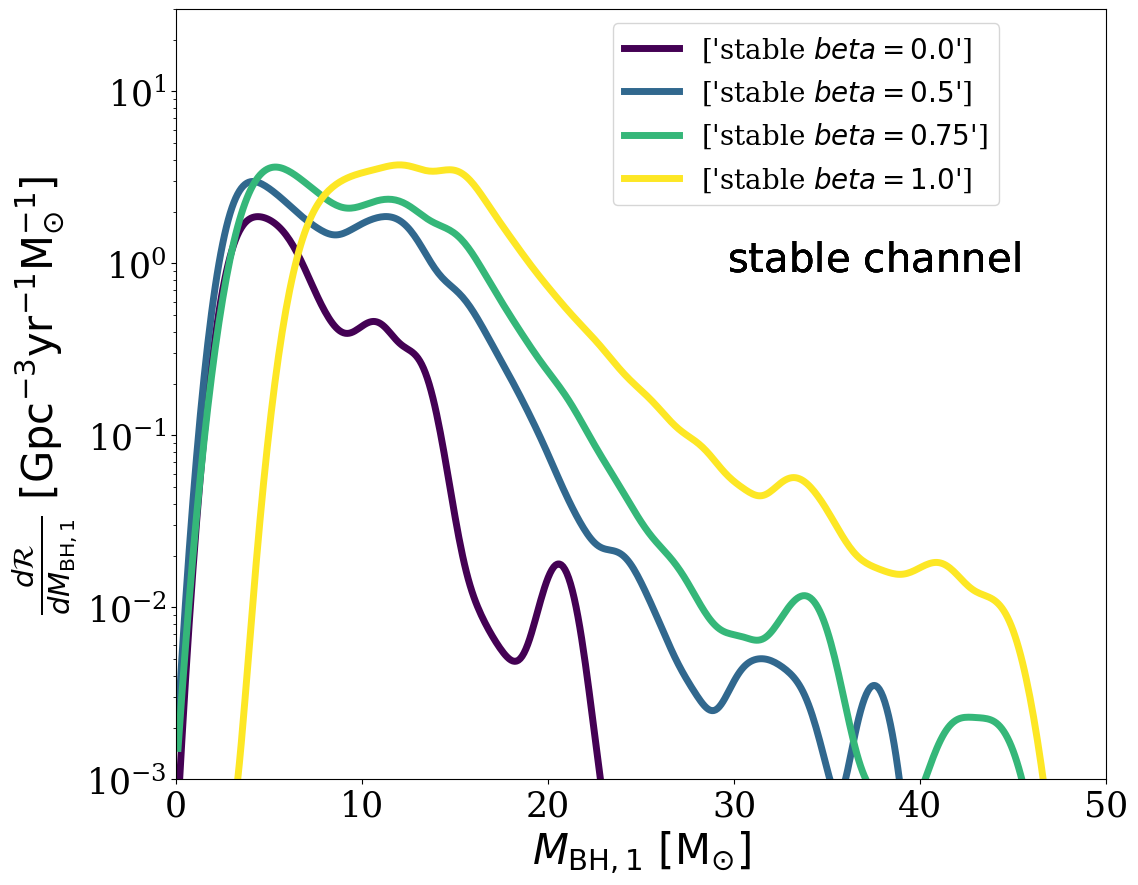

In [62]:

# Create a figure and axes
fig, ax = plt.subplots(figsize = (12, 10))

# List of simulation names
sim_names = ['faccFIXEDbeta%szetaHG6.0RemMassFRYER2012SNDELAYED/' % beta for beta in [0.0, 0.5, 0.75, 1.0]]

labels = [r' $beta = %s$' % beta for beta in [0.0, 0.5, 0.75, 1.0]]
colors = [cm.get_cmap('viridis')(i) for i in np.linspace(0, 1, len(sim_names))]

all_plot_lines, all_leg_labels = [], []
# Loop over simulation names
for i, sim_name in enumerate(sim_names):
    plot_lines, leg_labels = plot_mass_distribution(ax=ax, sim_dir='/mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/', 
                        sim_name=sim_name, x_key='M_lessMassive', Color= colors[i],SimLab = labels[i],
                        rate_key='Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned',
                        only_stable=True, only_CE=False, show_hist=True, show_KDE=True)
    
    all_plot_lines.append([plot_lines[i] for i in range(len(plot_lines)) ]) 
    all_leg_labels.append(leg_labels)
    
# Show the figure
# add legend for simulations
leg_args = {'loc':'upper right',  'bbox_to_anchor':[0.9, 1.], 'fontsize':20, 'title':''}
leg = plt.legend([l[0] for l in all_plot_lines], [l for l in all_leg_labels ],  **leg_args)
leg._legend_box.align = "right"

plt.show()

# Let's subdivide our histogram by certain properties

In [122]:
def plot_distribution(ax, x_vals, weights, bins, x_lim=(0.,50),  y_lim = (1e-3,30), color='#e388b0', 
                      linestyle='-', 
                      plot_ligo=False, show_hist=False, show_kde=True, channel_string = '',
                      sim_label='', xlabel=r'$M_{\mathrm{BH, 1}} \ \rm [M_{\odot}]$', ylabel=r'$\frac{d\mathcal{R}}{dM_{\mathrm{BH, 1} }} \ \mathrm{[Gpc^{-3}yr^{-1}M^{-1}_{\odot}]}$',
                      legend_args=None, legend1_args=None):
    """
    This function plots a KDE of the distribution.
    """
    # Calculate histogram
    hist, bin_edge = np.histogram(x_vals, weights=weights, bins=bins)
    y_vals = hist / np.diff(bin_edge)
    center_bins = (bin_edge[:-1] + bin_edge[1:]) / 2.

    # Calculate KDE
    kernel = stats.gaussian_kde(x_vals, bw_method='scott', weights=weights)

    # Plot histogram
    if show_hist:
        ax.step(center_bins, y_vals, where='mid',lw=2.5, color='k', marker='o', markersize=15)

    # Plot KDE
    if show_kde:
        x_kde = np.arange(0.1, 50., 0.1)
        kde_y_vals = kernel(x_kde) * sum(hist)
        plot_lines = ax.plot(x_kde, kde_y_vals, color=color, lw=5, ls=linestyle)
        
    # Plot LIGO data
    if plot_ligo:
        mass_1, mass_1_lower, mass_1_upper, mass_1_ppd  = read_ligo()
        ax.plot(mass_1, mass_1_ppd, lw=1.8, color=color_plpeak, zorder=1, label="$\mathrm{GWTC-3}$")
        ax.fill_between(mass_1, mass_1_lower, mass_1_upper, alpha=0.14,color=color_plpeak,zorder=0)
        legend1 = ax.legend(**legend1_args)
    
    # Set plot limits and labels
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)
    ax.set_yscale('log')

    # Set legend
    if legend_args is not None:
        ax.legend(legend_labels, **legend_args)
        
    if ax is None:
        # add legend for simulations
        legend_labels = [channel_string + sim_label]
        leg = ax.legend(**leg_args)
        leg = plt.legend([l[0] for l in plot_lines], [l for l in leg_labels ],  **leg_args)
        leg._legend_box.align = "right"

        # Legend for GWTC-3
        if plot_LIGO:
            plt.gca().add_artist(legend1)
        
        plt.show()
    else:
        return plot_lines[0] 
    

In [117]:
def read_and_mask(sim_dir='', rate_key='Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned',
                  sim_name='', x_key='M_moreMassive', 
                  bins=np.arange(0.,55,2.5), only_stable=True, only_CE=True):
    """
    This function reads and masks the data.
    """
    mass_binw = np.diff(bins)[0]    
    #############################
    # Reading data ##
    DCO = read_data(loc = os.path.join(sim_dir, sim_name, 'output', 'COMPAS_Output_wWeights.h5')) # DCO data
    
    # Rate data
    with h5.File(os.path.join(sim_dir, sim_name, 'output', 'COMPAS_Output_wWeights.h5'),'r') as File:
        if rate_key in File.keys():
            final_rate_key = rate_key
        else:
            final_rate_key = next((key for key in File.keys() if key.startswith('Rates_')), None)
        redshifts                 = File[final_rate_key]['redshifts'][()]
        DCO_mask                  = File[final_rate_key]['DCOmask'][()] # Mask from DCO to merging systems  
        intrinsic_rate_density    = File[final_rate_key]['merger_rate'][()]

    #############################
    # Masking data ##
    mask_start_t = time.time()
    CEcount = 'CE_Event_Count' if 'CE_Event_Count' in DCO.columns else 'CE_Event_Counter' # Old simulations use CE_Event_Count, newer ones CE_Event_Counter
    
    #first bring it to the same shape as the rate table
    merging_BBH = DCO[DCO_mask]
    # Are you interested in only stable or only CE channels?
    if np.logical_and(only_stable, only_CE):
        channel_bool = np.full(len(merging_BBH), True)
        channel_string = 'All'
    elif only_stable:
        channel_bool = merging_BBH[CEcount] == 0
        channel_string = 'stable'
    elif only_CE:
        channel_bool = merging_BBH[CEcount] > 0
        channel_string = 'CE'
    else:
        raise ValueError(f"Both only_stable ={only_stable} and only_CE={only_CE}, set at least one to true")
                
    # we exclude CHE systems
    not_CHE  = merging_BBH['Stellar_Type@ZAMS(1)'] != 16 
    BBH_bool = np.logical_and(merging_BBH['Stellar_Type(1)'] == 14, merging_BBH['Stellar_Type(2)'] == 14)
    
    # Apply all masks
    merging_BBH         = merging_BBH[BBH_bool * not_CHE  * channel_bool]
    Red_intr_rate_dens  = intrinsic_rate_density[BBH_bool* not_CHE * channel_bool, :]
    
    mask_end_t = time.time()
    print('done masking data: ', mask_end_t - mask_start_t, 'seconds')
    
    print(f'len(merging_BBH)={len(merging_BBH)} Rate = {np.sum(Weights)} Gpc-3 yr-1')
    
    return merging_BBH, Red_intr_rate_dens, bins, channel_string


Reading  /mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized//faccFIXEDbeta0.0zetaHG6.0RemMassFRYER2012SNDELAYED/output/COMPAS_Output_wWeights.h5
Done with reading DCO data for this file :)
Using rate key:  Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned
Masking data
done masking data:  0.21942353248596191 seconds
len(merging_BBH)=29947 Rate = 25.91663955737982 Gpc-3 yr-1
plot_lines Line2D(_child0)
plot_lines Line2D(_child1)
Reading  /mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized//faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/output/COMPAS_Output_wWeights.h5
Done with reading DCO data for this file :)
Using rate key:  Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Masking data
done masking data:  0.4309971332550049 seconds
len(merging_BBH)=221684 Rate = 2.452613800058 Gpc-3 yr-1
plot_lines Line2D(_child2)
plot_lines Line2D(_child3)
Reading  /mnt/home/lvanson/ceph/CompasOutp

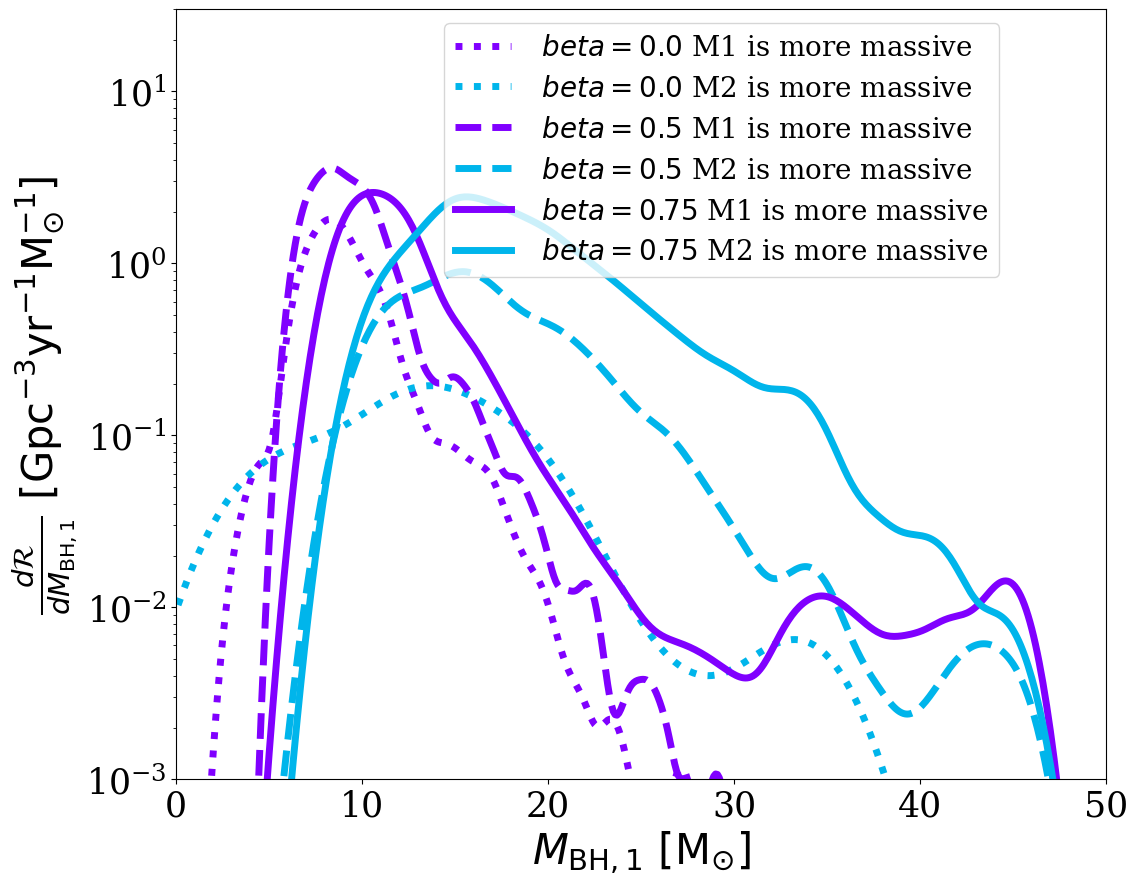

In [123]:
############################################################
# Create a figure and axes
fig, ax = plt.subplots(figsize = (12, 10))

# List of simulation names
sim_names = ['faccFIXEDbeta%szetaHG6.0RemMassFRYER2012SNDELAYED/' % beta for beta in [0.0, 0.5, 1.0]]#, 0.75, 1.0]]

labels = [r' $beta = %s$' % beta for beta in [0.0, 0.5, 0.75, 1.0]]
colors = [matplotlib.colormaps['rainbow'](i) for i in np.linspace(0, 1, 5)]
linestyles = [':', '--', '-']
all_plot_lines, all_leg_labels = [], []

# Loop over simulation names
for i, sim_name in enumerate(sim_names):
    # First read and mask the data
    merging_BBH, Red_intr_rate_dens, bins, channel_string = Read_and_Mask(sim_name=sim_name, 
                                            sim_dir='/mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/', 
                                            rate_key='Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned',
                                            bins=np.arange(0.,55,2.5), only_stable=True, only_CE=False)

    # Now lets add an extra mask
    M1_most_massive = merging_BBH['M_moreMassive'] == merging_BBH['Mass(1)']
    M2_most_massive = merging_BBH['M_moreMassive'] == merging_BBH['Mass(2)']
    
    bool_labels = ['M1 is more massive', 'M2 is more massive']
    
    # Use the average rate density per z-bin
    i_redshift = np.where(redshifts == 0.2)[0][0]
    
    for b, bool in enumerate([M1_most_massive, M2_most_massive]):
        Weights    = Red_intr_rate_dens[bool, i_redshift]
        x_vals     = merging_BBH['M_moreMassive'][bool]

        plot_lines =  plot_distribution(ax, x_vals, Weights, bins,
                        plot_ligo=False, show_hist=False, show_kde=True, 
                        x_lim=(0.,50),  y_lim = (1e-3,30), 
                        color= colors[b], linestyle = linestyles[i], 
                        xlabel=r'$M_{\mathrm{BH, 1}} \ \rm [M_{\odot}]$', 
                        ylabel=r'$\frac{d\mathcal{R}}{dM_{\mathrm{BH, 1} }} \ \mathrm{[Gpc^{-3}yr^{-1}M^{-1}_{\odot}]}$',
                        legend_args=None, legend1_args = None)
        
        # leg_labels = [channel_string + labels[i]]
        print('plot_lines', plot_lines)#, 'leg_labels', leg_labels)
        
        # all_plot_lines.append([plot_lines[i] for i in range(len(plot_lines)) ]) 
        all_plot_lines.append(plot_lines) 
        all_leg_labels.append(labels[i] + ' '+ bool_labels[b])

# Show the figure
# add legend for simulations
leg_args = {'loc':'upper right',  'bbox_to_anchor':[0.9, 1.], 'fontsize':20, 'title':''}
leg = plt.legend([l for l in all_plot_lines], [l for l in all_leg_labels ],  **leg_args)
leg._legend_box.align = "right"

plt.show()   
    
 